# Xử lý ảnh
## INT3404 1 ----- 7-9 Monday - 303GD2
## Diep Ng., Ph.D.
Mail-to: ngocdiep at vnu.edu.vn


In [16]:
# Week 2: Point operations

In [17]:
%matplotlib inline

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [19]:
plt.rcParams['figure.figsize'] = [12, 8]

# 2.1. Image negation


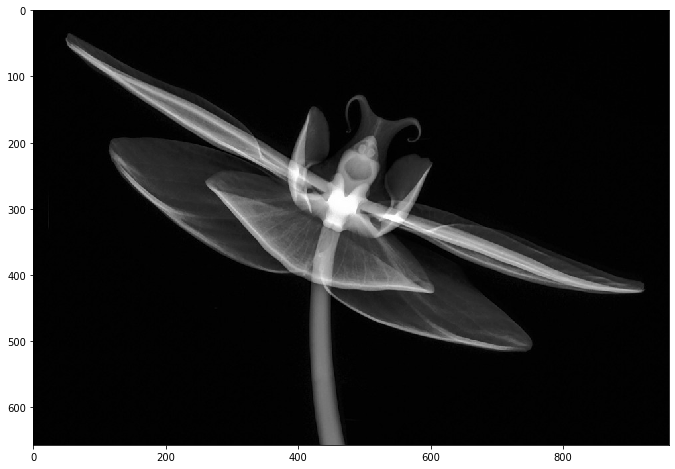

In [20]:
xray = cv2.imread("xray.jpeg", 0)
plt.imshow(xray, cmap='gray')

In [21]:
negation = 255 - xray
plt.imshow(negation, cmap='gray')

# 2.2. Gamma correction

In [22]:
# plot a quantization image of k level
def draw_quantization_img(levels, height=32):
    #convert it to an image
    img = [levels] *  height
    img = np.array(img)
    plt.imshow(img, cmap='gray')
#     plt.axis('off')

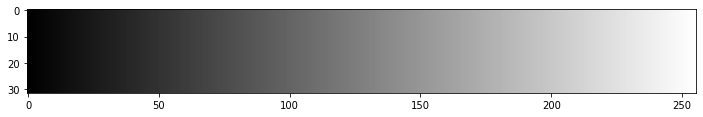

In [23]:
gray_256 = list(range(0, 256, 1))
draw_quantization_img(gray_256)


64


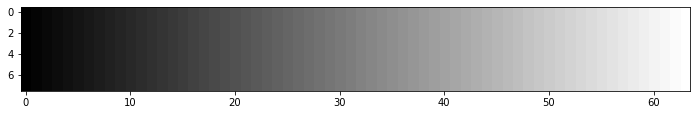

In [8]:
gray_64 = list(range(0, 256, 4))
print(len(gray_64))
draw_quantization_img(gray_64, height=8)


32


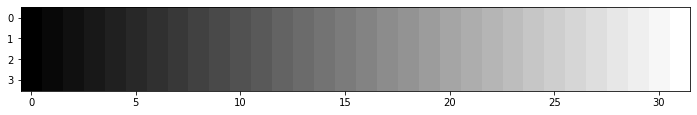

In [9]:
gray_32 = list(range(0, 256, 8))
print(len(gray_32))
draw_quantization_img(gray_32, height=4)


16


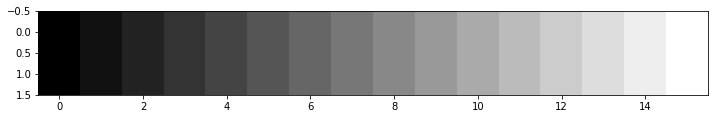

In [10]:
gray_16 = list(range(0, 256, 16))
print(len(gray_16))
draw_quantization_img(gray_16, height=2)


8


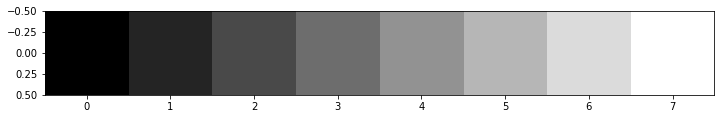

In [11]:
gray_8 = list(range(0, 256, 32))
print(len(gray_8))
draw_quantization_img(gray_8, height=1)


### Gamma

### $ v_{out} = v_{in}^\gamma$

$v_{in}$ : độ sáng thực tế (actual luminance value)

$v_{out}$: độ sáng cảm nhận (output luminance value)



In [12]:
def adjust_gamma(inlevels, gamma=1.0, debug=True):
    out = [l**gamma for l in inlevels]
    max_out = max(out)
    out = [int(l/max_out*256) for l in out]
    if debug:
        print(out)
    return out

[0, 17, 34, 51, 68, 85, 102, 119, 136, 153, 170, 187, 204, 221, 238, 256]


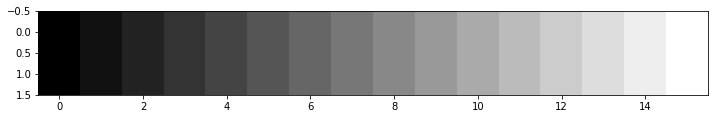

In [13]:
#no adjustment
draw_quantization_img(
        adjust_gamma(gray_16, gamma=1),
        height=2
)

[0, 0, 3, 7, 13, 22, 34, 47, 64, 83, 104, 129, 156, 186, 219, 256]


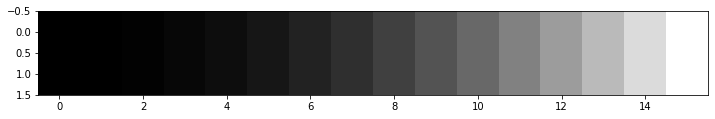

In [14]:
#with gamma >1, the levels are shifted toward the the darker end of the spectrum
draw_quantization_img(
        adjust_gamma(gray_16, gamma=2.2),
        height=2
)

[0, 74, 102, 123, 140, 155, 168, 181, 192, 202, 212, 222, 231, 239, 248, 256]


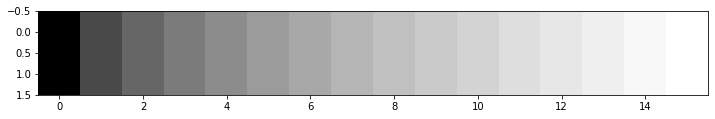

In [15]:
#with gamma < 1, lighter
draw_quantization_img(
        adjust_gamma(gray_16, gamma=1/2.2, debug=True),
        height=2
)

### Logarithmic graph



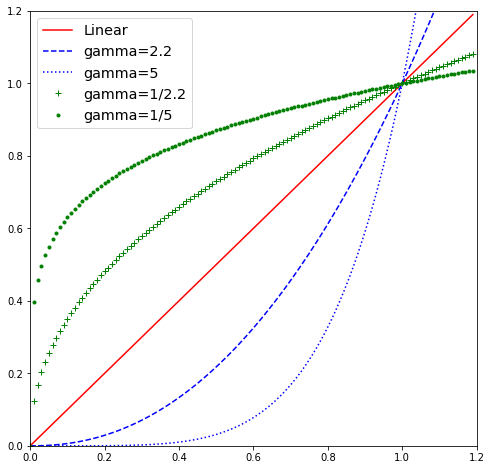

In [92]:
x = np.arange(0, 1.2, 0.01)

g1 = np.power(x, 1)
g2 = np.power(x, 2.2 ) #gamma=2.2
g3 = np.power(x, 5) #gamma=5


g4 = np.power(x, 1/2.2) 
g5 = np.power(x, 1/5)
fig, ax = plt.subplots()
ax.plot(x, g1, 'r', label='Linear')
ax.plot(x, g2, 'b--', label='gamma=2.2')
ax.plot(x, g3, 'b:', label='gamma=5')
ax.plot(x, g4, 'g+', label='gamma=1/2.2')
ax.plot(x, g5, 'g.', label='gamma=1/5')

ax.set_xlim([0, 1.2])
ax.set_ylim([0, 1.2])
# plt.yscale('log')
legend = ax.legend(loc='upper left', fontsize='x-large')

plt.rcParams['figure.figsize'] = [8, 8]
plt.show()



## Using gamma to adjust contrast

### 1. Low exposure

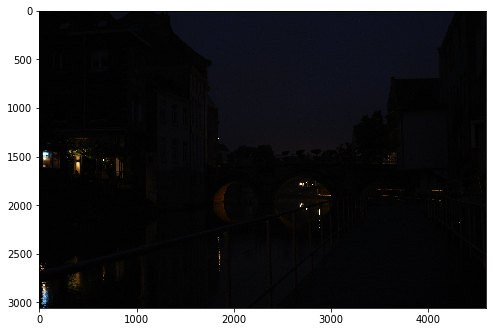

In [94]:
low = cv2.imread("low-exposure.jpg")
plt.imshow(low[:,:,::-1])

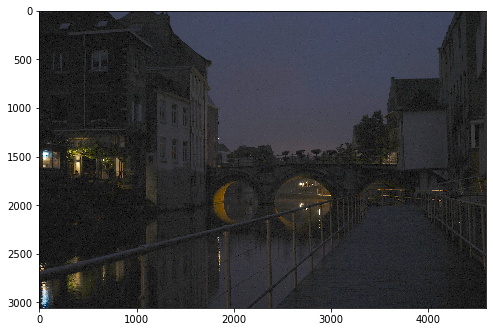

In [125]:
def adjust_image_gamma(image, gamma=1.0):
    image = np.power(image, gamma)
    max_val = np.max(image.ravel())
    image = image/max_val*255
    image = image.astype(np.uint8)
    return image

low_adjusted = adjust_image_gamma(low, 0.45)
plt.imshow(low_adjusted[:,:,::-1])

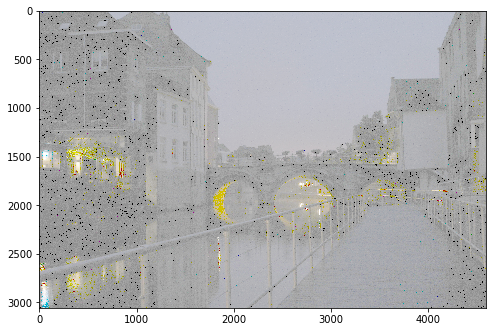

In [126]:
# what if gamma is too low?
low_adjusted = adjust_image_gamma(low, 0.1)
plt.imshow(low_adjusted[:,:,::-1])

In [127]:
%timeit low_adjusted = adjust_image_gamma(low, 0.1)

1.46 s ± 9.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [128]:
#faster way to compute
#reference: https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
def adjust_image_gamma_lookuptable(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    table = np.array([((i / 255.0) ** gamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

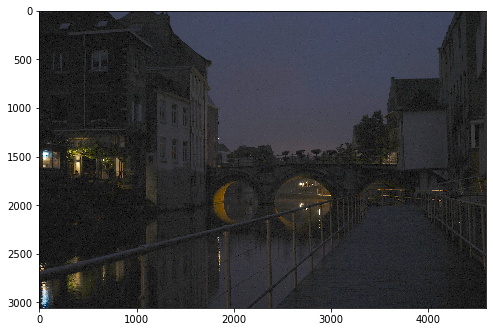

In [129]:
low_adjusted = adjust_image_gamma_lookuptable(low, 0.45)
plt.imshow(low_adjusted[:,:,::-1])

In [130]:
%timeit adjust_image_gamma_lookuptable(low, 0.45)

8.29 ms ± 42.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [131]:
### yeahhh

### Overexposure

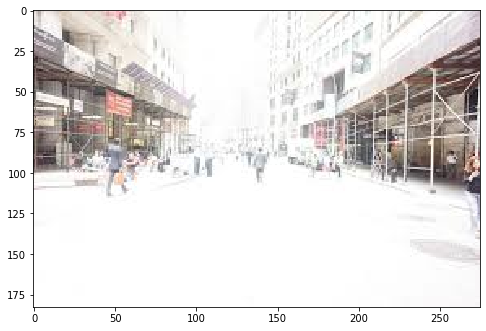

In [132]:
high = cv2.imread("high-exposure.jpg")
plt.imshow(high[:,:,::-1])

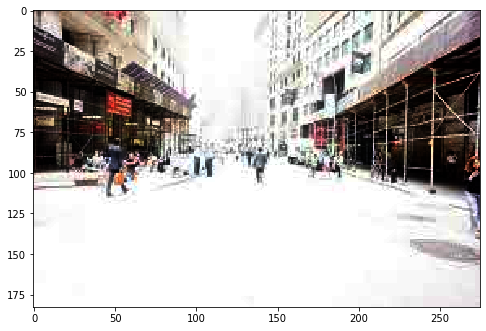

In [133]:
adjusted_high = adjust_image_gamma_lookuptable(high, 4)
plt.imshow(adjusted_high[:,:,::-1])

# 2.3. Correct using pixel transform

Reference: https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html

Dùng phép toán nhân và cộng $g(x) = \alpha f(x) + \beta$

$\alpha$ và $\beta$ còn được gọi là tham số gain và bias, hoặc tham số để điều chỉnh contrast (độ tương phản) và brightness (độ sáng)

Với ảnh số:

$g(i, j) = \alpha \cdot f(i, j) + \beta$

In [136]:
def pixel_transform(image, alpha=1.0, beta=0):
    '''
    out[pixel] = alpha * image[pixel] + beta
    '''
    output =  np.zeros(image.shape, image.dtype)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                output[y,x,c] = np.clip(alpha*image[y, x, c] + beta, 0, 255)
                
    return output

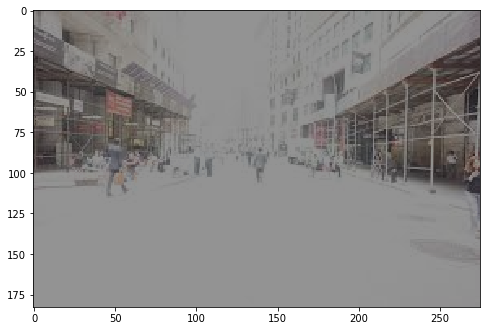

In [141]:
transformed_high = pixel_transform(high, 0.5, 20)
plt.imshow(transformed_high[:,:,::-1])

In [142]:
#hhmmm can we do better?

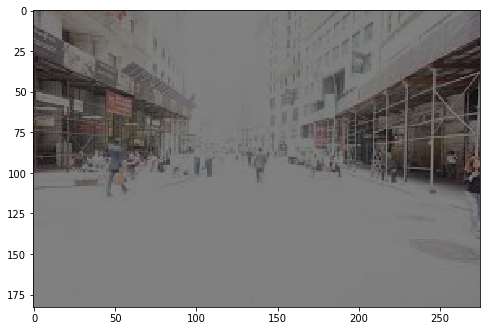

In [144]:
#anyway, a faster 
transformed_high = cv2.convertScaleAbs(high, 20, 0.5)
plt.imshow(transformed_high[:,:,::-1])

In [145]:
%timeit pixel_transform(high, 0.5, 20)

1.31 s ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [146]:
%timeit cv2.convertScaleAbs(high, 20, 0.5)

71 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# 2.4. Point operations for combining images


## 2.4.1. Image averaging for noise reduction


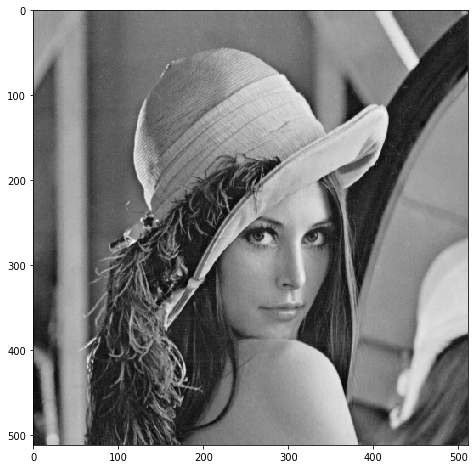

In [148]:
ori = cv2.imread("lena.jpg", 0)
plt.imshow(ori, cmap='gray')

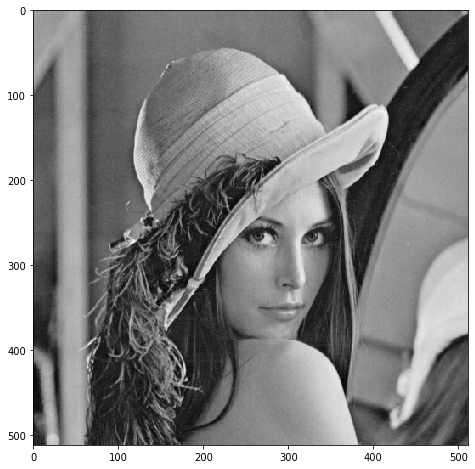

In [169]:
#now make several images from noisy
def generate_noise_image(img, mean=0, sigma=0):
    gaussian = np.random.normal(mean, sigma, img.shape)
    noisy_img = img + gaussian
    return noisy_img


def make_batch(img, num_output=4):
    sigmas = np.random.rand(4)*2
    noisy_imgs = [
                    generate_noise_image(img, sigma=sigma)
                   for sigma in sigmas
    ]
    return noisy_imgs


#make 4 images
noisy_imgs = make_batch(ori, num_output=4)
noisy_imgs = np.array(noisy_imgs)
denoised = np.mean(noisy_imgs, axis=0)
plt.imshow(denoised, cmap='gray')

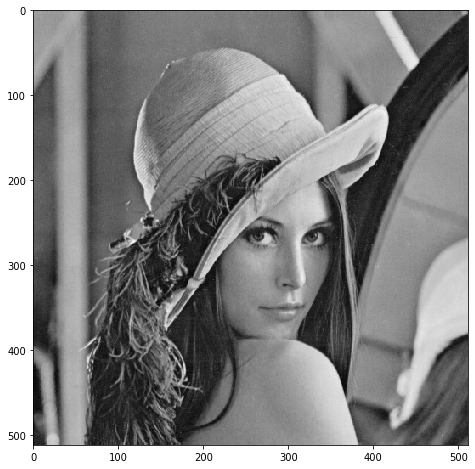

In [170]:
#make 25 images
noisy_imgs = make_batch(ori, num_output=25)
noisy_imgs = np.array(noisy_imgs)
denoised = np.mean(noisy_imgs, axis=0)
plt.imshow(denoised, cmap='gray')

## 2.4.2. Combination of different exposures for high-dynamic range imaging


In [201]:
hdr1 = cv2.imread("hdr1.jpeg")
hdr2 = cv2.imread("hdr2.jpeg")
hdr3 = cv2.imread("hdr3.jpeg")
hdr4 = cv2.imread("hdr4.jpeg")

stack = np.stack([hdr1, hdr2, hdr3, hdr4], axis=0)
stack.shape

(4, 2112, 2816, 3)

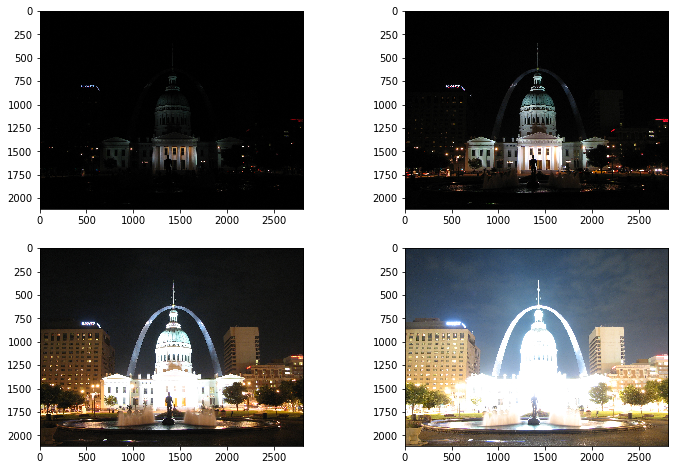

In [202]:
plt.rcParams['figure.figsize'] = [12, 8]
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(stack[i][:,:,::-1])

In [203]:
#Averaging to enhance contrast
hdr = np.mean(stack, axis=0)
hdr = hdr.astype(np.uint8)
hdr.shape

(2112, 2816, 3)

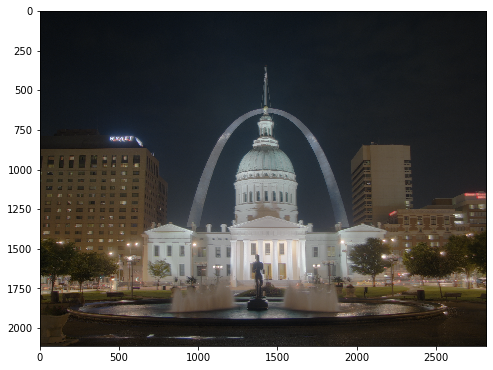

In [204]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.imshow(hdr[:,:,::-1])

## For curious students

Reference: https://www.learnopencv.com/high-dynamic-range-hdr-imaging-using-opencv-cpp-python/


In [192]:
# Align the images using AlignMTB
# The algorithm converts all the images to median threshold bitmaps (MTB)
# An MTB for an image is calculated by assigning the value 1 to pixels brighter than median luminance and 0 otherwise/
# An MTB is invariant to the exposure time.
# Therefore, the MTBs can be aligned without requiring us to specifying the exposure time

In [205]:
alignMTB = cv2.createAlignMTB()
alignMTB.process(stack, stack)

In [207]:
# Obtain Camera Response Function (CRF)
times = np.array([ 1/30.0, 0.25, 2.5, 15.0 ], dtype=np.float32) #exposure time of each image, known from metadata
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(stack, times)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


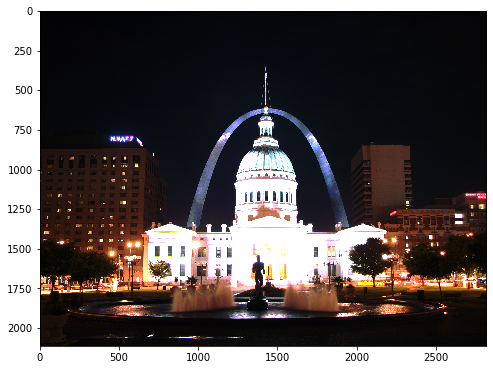

In [208]:
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(stack, times, responseDebevec)
plt.imshow(hdrDebevec[:,:,::-1])

In [212]:
# Tone mapping = Converting a HDR image to an 8-bit per channel image
# using HDR, the relative brightness information was recovered
# we need to convert the information as a 24-bit image for display

#check hdrDebevec
hdrDebevec[10:20, 10:20]

array([[[0.02337988, 0.01373778, 0.0108448 ],
        [0.02325735, 0.0135258 , 0.01061967],
        [0.02301772, 0.01365845, 0.0106386 ],
        [0.02226447, 0.01326527, 0.00997145],
        [0.02278442, 0.01358335, 0.01136626],
        [0.02131137, 0.01220103, 0.00938267],
        [0.02285972, 0.01369385, 0.01130131],
        [0.02405641, 0.01398584, 0.01413908],
        [0.02468085, 0.01433554, 0.01336828],
        [0.02423481, 0.01422949, 0.01255944]],

       [[0.02384082, 0.01399881, 0.01104737],
        [0.02421025, 0.01421678, 0.01120664],
        [0.02322699, 0.013816  , 0.01060489],
        [0.02423416, 0.01438694, 0.01117838],
        [0.02537469, 0.01461322, 0.01436157],
        [0.02388573, 0.01356775, 0.01268862],
        [0.02366121, 0.01356386, 0.01239939],
        [0.02313343, 0.01313945, 0.01216698],
        [0.02258362, 0.0130611 , 0.01080137],
        [0.0235699 , 0.01371612, 0.0121934 ]],

       [[0.02291146, 0.01335014, 0.01075939],
        [0.02461979, 0.0147301

In [213]:
#Common parameters of the different tone mapping algorithms
# 1. gamma. For gamma correction; gamma < 1 darkens the image; gamma >1 brightens the image
# 2. saturation: to increase or decrease the amount of saturation. Higher -> colors are richer and more intense
#     Closer to zero, colors fade away to grayscale
# 3. contrast: controls the contrast. = log(maxPixelvalue/minPixelvalue)

#Opencv implements 4 tone mappings


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


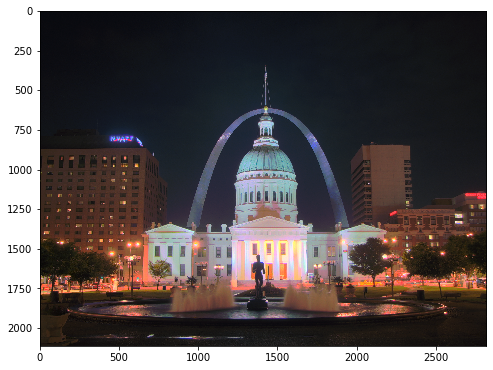

In [220]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago
plt.imshow(ldrDrago[:,:,::-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


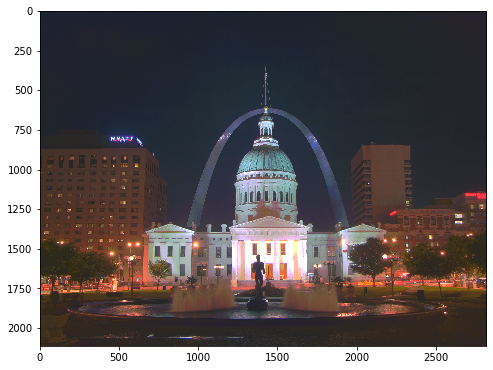

In [221]:
# Tonemap using Durand's method obtain 24-bit color image
tonemapDurand = cv2.createTonemapDurand(1.5,4,1.0,1,1)
ldrDurand = tonemapDurand.process(hdrDebevec)
ldrDurand = 3 * ldrDurand
plt.imshow(ldrDurand[:,:,::-1])